In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install --upgrade plotly
!pip install pmdarima
print("Done")

Done


In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
#import category_encoders as ce
from scipy import stats
from numpy import mean, std
import lightgbm as lgb
import seaborn as sns
#from catboost import CatBoostRegressor
import plotly.express as px
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
import seaborn as sns

SEED = 42

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")
check = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")

In [6]:
check["population"]

0         38928341.0
1         38928341.0
2         38928341.0
3         38928341.0
4         38928341.0
             ...    
102470    14862927.0
102471    14862927.0
102472    14862927.0
102473    14862927.0
102474    14862927.0
Name: population, Length: 102475, dtype: float64

In [7]:
dataset_UK = df[df["location"] == "United Kingdom"]  

In [8]:
dataset_UK["Mortality_Rate"] = dataset_UK["new_deaths"]/ dataset_UK["population"]

In [9]:
features = ["date", "new_cases", "reproduction_rate", "icu_patients", "hosp_patients", "new_tests", "positive_rate", "people_vaccinated", "people_fully_vaccinated", 
            "new_vaccinations", "stringency_index", "Mortality_Rate"]

In [10]:
dataset_UK = dataset_UK[features]

In [11]:
dataset_UK["Lockdown"] = ""

yes1 = (dataset_UK["date"] >= "2020-05-10") & (dataset_UK["date"] <= "2020-06-23")
yes2 = (dataset_UK["date"] >= "2020-10-31") & (dataset_UK["date"] <= "2020-12-02")
yes3 = (dataset_UK["date"] >= "2020-12-21") & (dataset_UK["date"] <= "2021-04-17")

dataset_UK["Lockdown"][yes1] = 1
dataset_UK["Lockdown"][yes2] = 1
dataset_UK["Lockdown"][yes3] = 1

dataset_UK["Lockdown"] = dataset_UK["Lockdown"].replace([''], 0)

dataset_UK["Variant"] = ""
dataset_UK["Vaccine"] = ""

alpha = (dataset_UK["date"] >= "2020-09-15") & (dataset_UK["date"] <= "2021-05-13")
delta = (dataset_UK["date"] > "2021-05-13")

dataset_UK["Variant"][alpha] = "Alpha"
dataset_UK["Variant"][delta] = "Delta"

dataset_UK["Variant"] = dataset_UK["Variant"].replace([''], "First")

no_vaccine = (dataset_UK["date"] >= "2020-05-01") & (dataset_UK["date"] <= "2021-01-09")
pfizer = (dataset_UK["date"] > "2021-01-09") 

dataset_UK["Vaccine"][no_vaccine] = "No Vaccine"
dataset_UK["Vaccine"][pfizer] = "Pfizer"

In [12]:
dataset_UK = dataset_UK[dataset_UK["date"] >= "2020-05-01"]

In [13]:
dataset_UK.drop(["stringency_index"], axis = 1, inplace = True)

In [14]:
dataset_UK.isna().sum()

date                         0
new_cases                    0
reproduction_rate            1
icu_patients                 1
hosp_patients                1
new_tests                    3
positive_rate                3
people_vaccinated          251
people_fully_vaccinated    255
new_vaccinations           256
Mortality_Rate               0
Lockdown                     0
Variant                      0
Vaccine                      0
dtype: int64

In [15]:
dataset_UK['people_vaccinated'] = dataset_UK["people_vaccinated"].fillna(0)
dataset_UK['people_fully_vaccinated'] = dataset_UK["people_fully_vaccinated"].fillna(0)
dataset_UK['new_vaccinations'] = dataset_UK["new_vaccinations"].fillna(0)

In [16]:
dataset_UK = dataset_UK[dataset_UK["date"] < "2021-07-12"]

In [17]:
l1 = {
    "First" : 0,
    "Alpha" : 1,
    "Delta" : 2
}

l2 = {
    'No Vaccine' : 0,
     'Pfizer' : 1
}

dataset_UK["Variant"] = dataset_UK["Variant"].map(l1)
dataset_UK["Vaccine"] = dataset_UK["Vaccine"].map(l2)

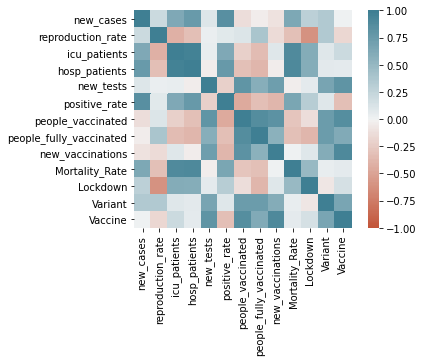

In [18]:
#data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')

corr = dataset_UK.corr()
ax = sns.heatmap(
    corr, 
    vmin = -1, vmax = 1, center = 0,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = True
)

In [19]:
dataset_UK["Lockdown"].unique()

array([0, 1])

In [20]:
dataset_UK["Vaccine"].unique()

array([0, 1])

In [21]:
dataset_UK["Variant"].unique()

array([0, 1, 2])

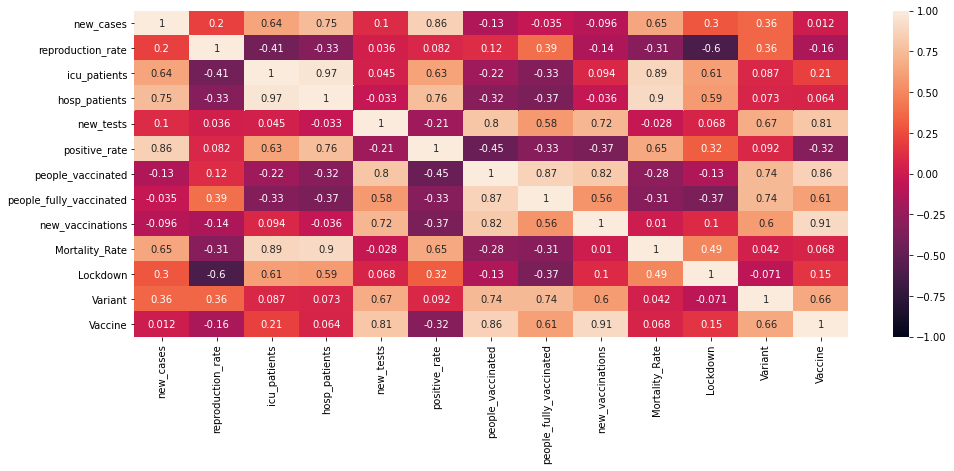

In [22]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(dataset_UK.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
#heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [23]:
dataset_UK.set_index("date", inplace = True)

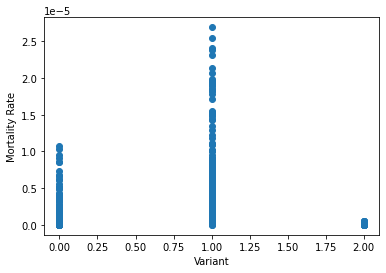

In [24]:
plt.scatter(dataset_UK["Variant"], dataset_UK["Mortality_Rate"])


plt.xlabel("Variant") #x label
plt.ylabel("Mortality Rate") #y label
plt.show()

In [25]:
dataset_UK.isna().sum()

new_cases                  0
reproduction_rate          0
icu_patients               0
hosp_patients              0
new_tests                  0
positive_rate              0
people_vaccinated          0
people_fully_vaccinated    0
new_vaccinations           0
Mortality_Rate             0
Lockdown                   0
Variant                    0
Vaccine                    0
dtype: int64

In [26]:
dataset_UK.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Mortality_Rate,Lockdown,Variant,Vaccine
date,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0.000010,0,0,0
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0.000009,0,0,0
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0.000004,0,0,0
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0.000004,0,0,0
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0.000011,0,0,0


In [27]:
features = ["new_cases", "reproduction_rate", "icu_patients", "hosp_patients", "new_tests", "positive_rate", "people_vaccinated", "people_fully_vaccinated", 
            "new_vaccinations", "Lockdown", "Variant", "Vaccine", "Mortality_Rate"]

In [28]:
dataset_UK = dataset_UK[features]

In [29]:
dataset_UK.tail()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,Mortality_Rate
date,,,,,,,,,,,,,
2021-07-07,32061.0,1.31,417.0,2651.0,1237992.0,0.024,45601445.0,34198779.0,258430.0,0,2,1,4.861090e-07
2021-07-08,32096.0,1.30,417.0,2736.0,1114234.0,0.025,45697875.0,34374246.0,271897.0,0,2,1,5.303008e-07
2021-07-09,35885.0,1.30,437.0,2907.0,889492.0,0.026,45787958.0,34553065.0,268902.0,0,2,1,4.419173e-07
2021-07-10,31835.0,1.30,448.0,2999.0,733853.0,0.027,45881721.0,34764511.0,305209.0,0,2,1,5.008396e-07
2021-07-11,31382.0,1.31,454.0,3142.0,1118189.0,0.028,45923721.0,34872131.0,149620.0,0,2,1,3.829950e-07


In [30]:
check = check[check["location"] == "United Kingdom"]

In [31]:
check["gdp_per_capita"]

96578    39753.244
96579    39753.244
96580    39753.244
96581    39753.244
96582    39753.244
           ...    
97104    39753.244
97105    39753.244
97106    39753.244
97107    39753.244
97108    39753.244
Name: gdp_per_capita, Length: 531, dtype: float64

In [32]:
dataset_UK["GDP_PER_CAPITA"] = 39753.244

In [33]:
features = ["new_cases", "reproduction_rate", "icu_patients", "hosp_patients", "new_tests", "positive_rate", "people_vaccinated", "people_fully_vaccinated", 
            "new_vaccinations", "Lockdown", "Variant", "Vaccine", "GDP_PER_CAPITA",  "Population", "Mortality_Rate"]

In [34]:
dataset_UK["Population"] =  67886004.0

In [35]:
dataset_UK = dataset_UK[features]

In [36]:
dataset_UK.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [37]:
len(dataset_UK)

437

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : 2.220446049250313e-16
The Mean absolute error is : 0.810722961639796
The Mean squared error score is : 1.0
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


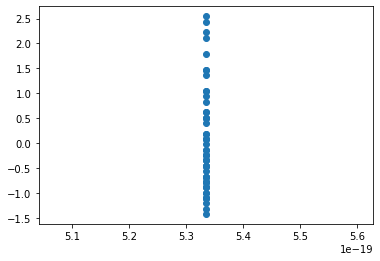

In [38]:

train = dataset_UK[ : 380]
test = dataset_UK[380 : ]

features = ["Population", "Mortality_Rate"]

train = train[features]
test = test[features]

X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]

X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)

estimators = [
             # ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))

]

reg = StackingRegressor(
    estimators = estimators ,
    #final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

plt.scatter(predict, Y_test)

In [39]:
a = [0.0025, -0.03, 0.04, 0.07,-0.02, 0.03, 0.0032, 0.0, -0.0015, 0.024, 0.00211]
b = ["New cases", "Reproduction Rate", "ICU patients", "Hospital Patients", "New tests", "Positive rate", "People vaccinated", "People fully vaccinated", "New vaccinations", "GDP per capita", "Population"]

In [40]:
a = -4.6631374139849413e-07
a.as_integer_ratio()

(-262511299, 562949953421312)

In [41]:
-262511299/562949953421312

-4.6631374139849413e-07

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : 0.0
The Mean absolute error is : 0.8367798186728023
The Mean squared error score is : 0.9999999999999998
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


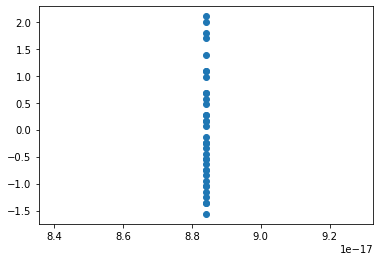

In [42]:

train = dataset_UK[ : 400]
test = dataset_UK[400 : ]

features = ["reproduction_rate", "Mortality_Rate"]

train = train[features]
test = test[features]

X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]

X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)

estimators = [
             # ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))

]

reg = StackingRegressor(
    estimators = estimators ,
    #final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

plt.scatter(predict, Y_test)

In [43]:
dataset_UK

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,1.031140e-05
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,8.617387e-06
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,3.726836e-06
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,4.021447e-06
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,1.067967e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-07,32061.0,1.31,417.0,2651.0,1237992.0,0.024,45601445.0,34198779.0,258430.0,0,2,1,39753.244,67886004.0,4.861090e-07
2021-07-08,32096.0,1.30,417.0,2736.0,1114234.0,0.025,45697875.0,34374246.0,271897.0,0,2,1,39753.244,67886004.0,5.303008e-07
2021-07-09,35885.0,1.30,437.0,2907.0,889492.0,0.026,45787958.0,34553065.0,268902.0,0,2,1,39753.244,67886004.0,4.419173e-07


------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : 0.0
The Mean absolute error is : 0.8367798186728023
The Mean squared error score is : 0.9999999999999998
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


Text(0.5, 1.0, 'Vaccine')

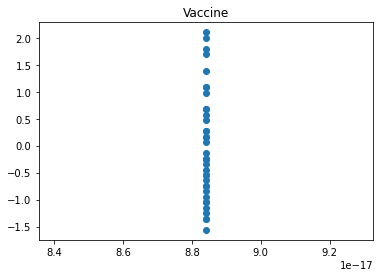

In [44]:
train = dataset_UK[ : 400]
test = dataset_UK[400 : ]

features = ["Vaccine", "Mortality_Rate"]

train = train[features]
test = test[features]

X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]

X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)

estimators = [
              #("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))

]

reg = StackingRegressor(
    estimators = estimators ,
  #  final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

plt.scatter(predict, Y_test)
plt.title("Vaccine")

In [45]:
a = [-0.448477840488116, 0.06208363651735416, 0.3931197129900058, 0.46567331528211864 ,-0.16185721697723876,0.31675936520288284, -0.30533947410537343, -0.893424282470713, -0.1543368221476884, -0.1771739047244627, -0.1771739047244627, -0.13745758649892226, -0.3314571071106014, -0.401488034385443]
b = ["New cases", "Reproduction Rate", "ICU patients", "Hospital Patients", "New tests", "Positive rate", "People vaccinated", "People fully vaccinated", "New vaccinations", "GDP per capita", "Population", "Lockdown", "Variant", "Vaccine"]
c = [0.7558059440435333, 0.82877344017137, 0.6124008005366653, 0.6274022578161009, 0.8368714439721661, 0.764981523883939, 0.946662279750325, 0.8466737757705006, 0.8369732670682634, 0.8368064276801915, 0.8328905430725957,0.8368207006419054, 0.8368888757965631 ]
d = [0.818959014590692, 0.9661863147926321, 0.6096716257999564, 0.5985923022656644, 1.0041944759203594, 0.8449910899651566, 1.3370653269649777, 1.0294447574093655, 0.9998802061784641, 1.0000001077006406, 1.0023009033518422, 1.0000002542286843, 1.0000018091268437]

In [46]:
train = dataset_UK[ : 400]
test = dataset_UK[400 : ]
features = ["icu_patients", "Mortality_Rate"]
train = train[features]
test = test[features]
X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]
X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))]
reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)
reg.fit(X_train, Y_train)
predict = reg.predict(X_test)
r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)


print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")

The r2 score is : 0.3931197129900058
The Mean absolute error is : 0.6443812526235317
The Mean squared error score is : 0.6068802870099941
------------------------------------------------


In [47]:
predict

array([-0.6594313 , -0.6594313 , -0.6594313 , -0.6594313 , -0.6594313 ,
       -0.6594313 , -0.6594313 , -0.6594313 , -0.6594313 , -0.6594313 ,
       -0.45331423, -0.45331423, -0.45331423, -0.22541009, -0.27242428,
       -0.45331423, -0.14141523, -0.02674649, -0.02674649,  0.31955313,
        0.18625071,  0.14812336,  0.45113552,  0.33331338,  0.38434098,
        0.42734176,  0.33331338,  0.33331338,  0.45801565,  0.55749079,
        0.55749079,  0.6022116 ,  0.51649671,  0.51649671,  0.569531  ,
        2.3285496 ,  2.3285496 ])

In [48]:
train

,icu_patients,Mortality_Rate
date,,
2020-05-01,2178.0,1.031140e-05
2020-05-02,2068.0,8.617387e-06
2020-05-03,2009.0,3.726836e-06
2020-05-04,1936.0,4.021447e-06
2020-05-05,1874.0,1.067967e-05
...,...,...
2021-05-31,122.0,2.946115e-08
2021-06-01,136.0,0.000000e+00
2021-06-02,129.0,1.767669e-07


In [49]:
train = dataset_UK[ : 400]
test = dataset_UK[400 : ]

X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]
X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))]
reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)
reg.fit(X_train, Y_train)
predict = reg.predict(X_test)


r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")

------------------------------------------------
The r2 score is : 0.24137591963978544
The Mean absolute error is : 0.7011641882846458
The Mean squared error score is : 0.7586240803602143
------------------------------------------------


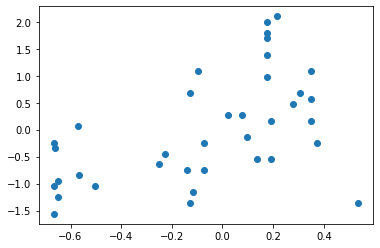

In [50]:
plt.scatter(predict, Y_test)

In [51]:
train = dataset_UK[ : 400]
test = dataset_UK[400 : ]

features = ["icu_patients", "hosp_patients", "positive_rate", "reproduction_rate", "Mortality_Rate"]
train = train[features]
test = test[features]


X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]
X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))]
reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)
reg.fit(X_train, Y_train)
predict = reg.predict(X_test)


r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")

------------------------------------------------
The r2 score is : 0.4571212784338865
The Mean absolute error is : 0.6104936042764484
The Mean squared error score is : 0.5428787215661134
------------------------------------------------


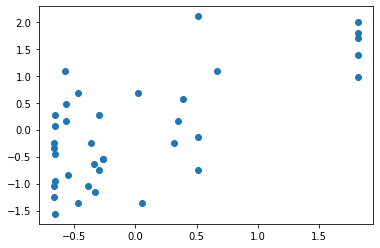

In [52]:
plt.scatter(predict, Y_test);

In [53]:
len(dataset_UK)

437

In [54]:
train = dataset_UK[ : 430]
test = dataset_UK[430 : ]

features = ["icu_patients", "positive_rate", "reproduction_rate", "Mortality_Rate"]
train = train[features]
test = test[features]


X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]
X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))]
reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)
reg.fit(X_train, Y_train)
predict = reg.predict(X_test)


r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")

------------------------------------------------
The r2 score is : 0.03900109635836335
The Mean absolute error is : 0.8230185893692469
The Mean squared error score is : 0.960998903641637
------------------------------------------------


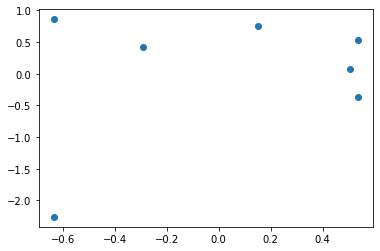

In [55]:
plt.scatter(predict, Y_test);

In [56]:
train = dataset_UK[ : 430]
test = dataset_UK[430 : ]

features = ["icu_patients", "positive_rate", "reproduction_rate", "Mortality_Rate"]
train = train[features]
test = test[features]


X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]
X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", Lasso(alpha = 1))]
reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)
reg.fit(X_train, Y_train)
predict = reg.predict(X_test)


r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")

------------------------------------------------
The r2 score is : 0.03900109635836335
The Mean absolute error is : 0.8230185893692469
The Mean squared error score is : 0.960998903641637
------------------------------------------------


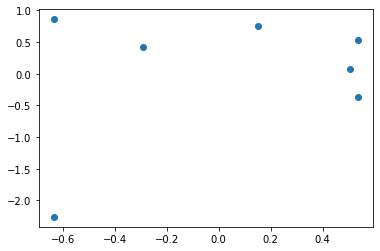

In [57]:
plt.scatter(predict, Y_test);

In [58]:
train = dataset_UK[ : 430]
test = dataset_UK[430 : ]



X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]
X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test)


reg = RandomForestRegressor(random_state = 42)
reg.fit(X_train, Y_train)
predict = reg.predict(X_test)


r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")

------------------------------------------------
The r2 score is : -0.03793767723713182
The Mean absolute error is : 0.8623885104488805
The Mean squared error score is : 1.037937677237132


In [59]:
importances = reg.feature_importances_

In [60]:
importances

array([2.04592777e-02, 1.41072939e-02, 2.26368387e-01, 6.29146979e-01,
       5.35971250e-02, 1.11653931e-02, 8.47969031e-03, 6.59970412e-03,
       2.84929338e-02, 1.73055083e-04, 7.96884133e-04, 6.13276350e-04,
       0.00000000e+00, 0.00000000e+00])

In [61]:
type(importances)

numpy.ndarray

In [62]:
main = [2.16801456e-02, 1.33716547e-02, 2.10386557e-01, 6.37019444e-01,
       5.81100023e-02, 1.38647949e-02, 1.05497670e-02, 4.97986780e-03,
       2.90343084e-02, 2.49901831e-04, 3.09969184e-04, 4.43587256e-04,
       0.00000000e+00, 0.00000000e+00]

In [63]:
data = pd.DataFrame(main)

In [64]:
data

,0
0,0.021680
1,0.013372
2,0.210387
3,0.637019
4,0.058110
5,0.013865
6,0.010550
7,0.004980
8,0.029034
9,0.000250


In [65]:
data

,0
0,0.021680
1,0.013372
2,0.210387
3,0.637019
4,0.058110
5,0.013865
6,0.010550
7,0.004980
8,0.029034
9,0.000250


In [66]:
dataset_UK.to_csv("dataset.csv")

In [67]:
dataset_UK.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Text(0, 0.5, 'Frequency')

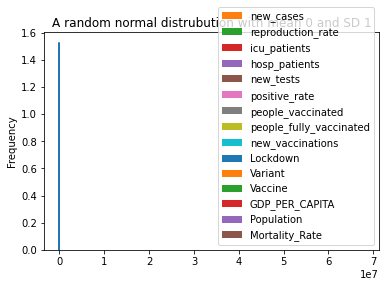

In [69]:
fig, ax = plt.subplots()
dataset_UK["reproduction_rate"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 1')
dataset_UK.plot.hist(density=True, ax=ax)
ax.set_ylabel('Frequency')

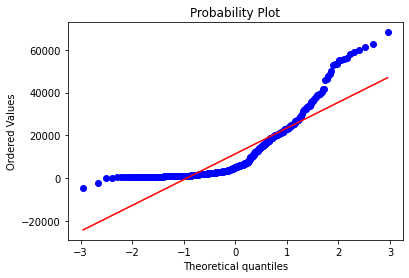

In [70]:
res = stats.probplot(dataset_UK["new_cases"], plot=plt)
plt.show()

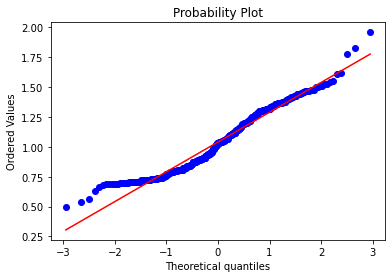

In [71]:
res = stats.probplot(dataset_UK["reproduction_rate"], plot=plt)
plt.show()

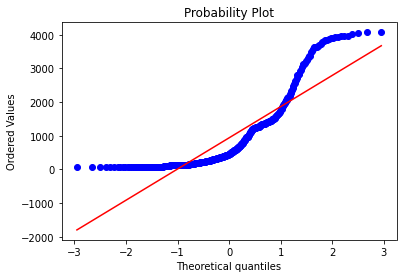

In [72]:
res = stats.probplot(dataset_UK["icu_patients"], plot=plt)
plt.show()

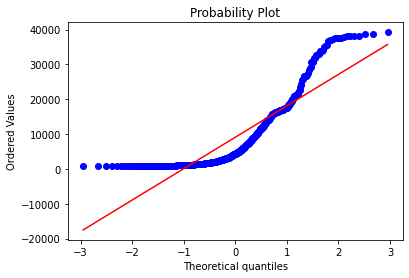

In [73]:
res = stats.probplot(dataset_UK["hosp_patients"], plot=plt)
plt.show()

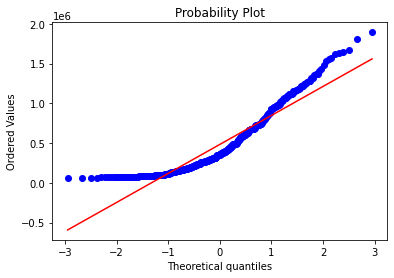

In [74]:
res = stats.probplot(dataset_UK["new_tests"], plot=plt)
plt.show()

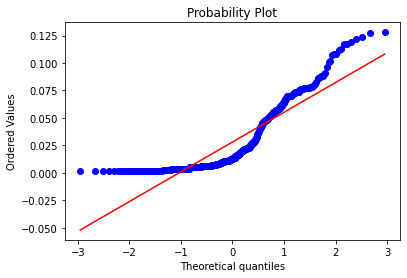

In [75]:
res = stats.probplot(dataset_UK["positive_rate"], plot=plt)
plt.show()

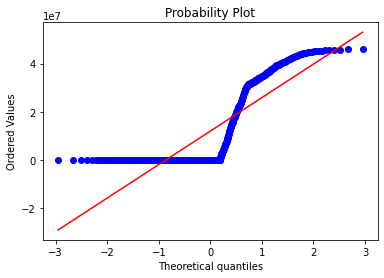

In [76]:
res = stats.probplot(dataset_UK["people_vaccinated"], plot=plt)
plt.show()

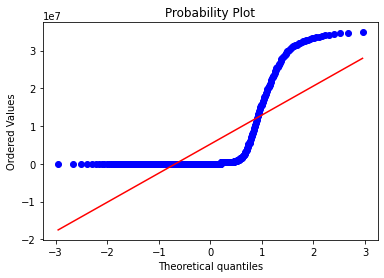

In [77]:
res = stats.probplot(dataset_UK["people_fully_vaccinated"], plot=plt)
plt.show()

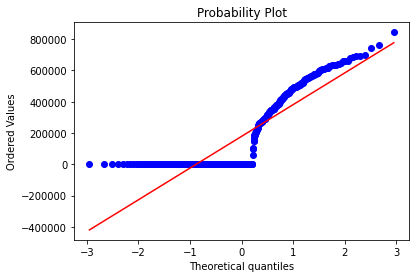

In [78]:
res = stats.probplot(dataset_UK["new_vaccinations"], plot=plt)
plt.show()

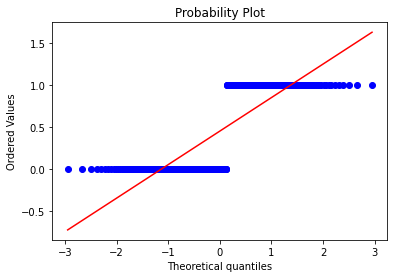

In [79]:
res = stats.probplot(dataset_UK["Lockdown"], plot=plt)
plt.show()

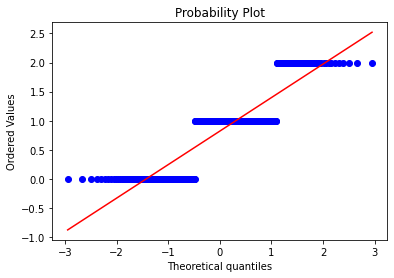

In [80]:
res = stats.probplot(dataset_UK["Variant"], plot=plt)
plt.show()

In [81]:
dataset_UK.columns

Index(['new_cases', 'reproduction_rate', 'icu_patients', 'hosp_patients',
       'new_tests', 'positive_rate', 'people_vaccinated',
       'people_fully_vaccinated', 'new_vaccinations', 'Lockdown', 'Variant',
       'Vaccine', 'GDP_PER_CAPITA', 'Population', 'Mortality_Rate'],
      dtype='object')

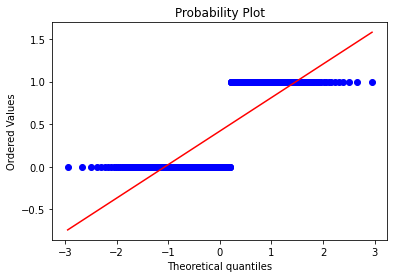

In [82]:
res = stats.probplot(dataset_UK["Vaccine"], plot=plt)
plt.show()

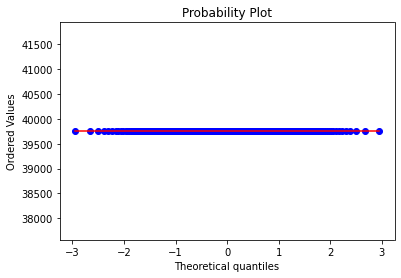

In [83]:
res = stats.probplot(dataset_UK["GDP_PER_CAPITA"], plot=plt)
plt.show()

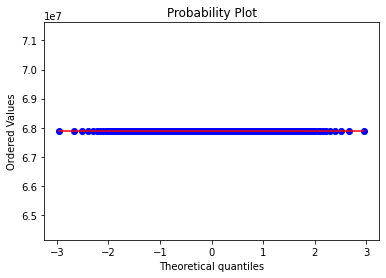

In [84]:
res = stats.probplot(dataset_UK["Population"], plot=plt)
plt.show()

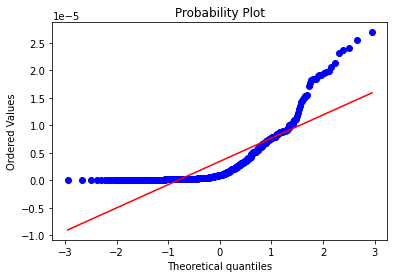

In [85]:
res = stats.probplot(dataset_UK["Mortality_Rate"], plot=plt)
plt.show()

In [86]:
import matplotlib.pyplot as plt

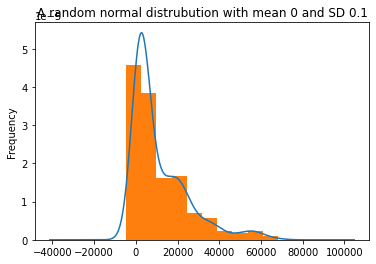

In [87]:
fig, ax = plt.subplots()
dataset_UK["new_cases"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["new_cases"].plot.hist(density=True, ax=ax)

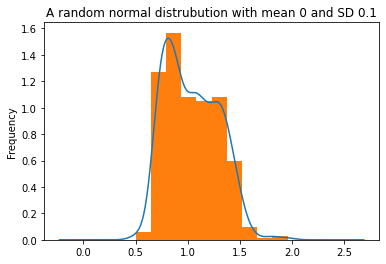

In [88]:
fig, ax = plt.subplots()
dataset_UK["reproduction_rate"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["reproduction_rate"].plot.hist(density=True, ax=ax)

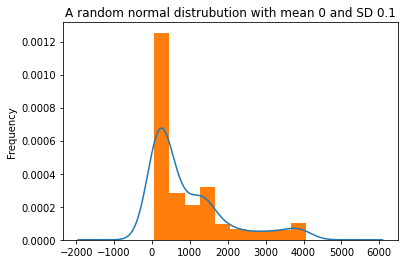

In [89]:
fig, ax = plt.subplots()
dataset_UK["icu_patients"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["icu_patients"].plot.hist(density=True, ax=ax)

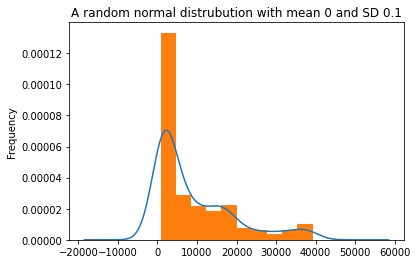

In [90]:
fig, ax = plt.subplots()
dataset_UK["hosp_patients"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["hosp_patients"].plot.hist(density=True, ax=ax)

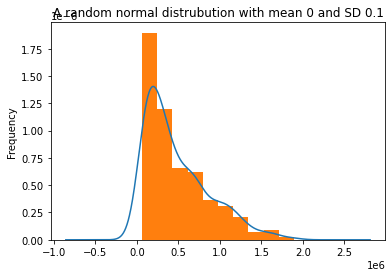

In [91]:
fig, ax = plt.subplots()
dataset_UK["new_tests"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["new_tests"].plot.hist(density=True, ax=ax)

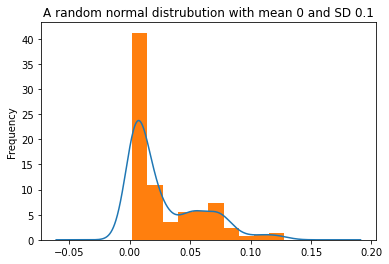

In [92]:
fig, ax = plt.subplots()
dataset_UK["positive_rate"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["positive_rate"].plot.hist(density=True, ax=ax)

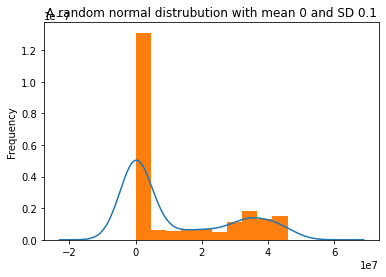

In [93]:
fig, ax = plt.subplots()
dataset_UK["people_vaccinated"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["people_vaccinated"].plot.hist(density=True, ax=ax)

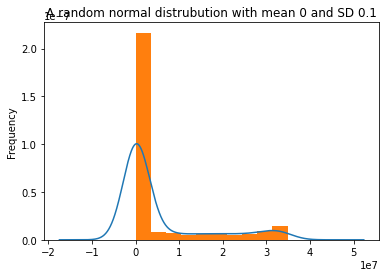

In [94]:
fig, ax = plt.subplots()
dataset_UK["people_fully_vaccinated"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["people_fully_vaccinated"].plot.hist(density=True, ax=ax)

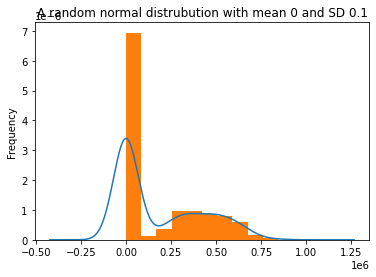

In [95]:
fig, ax = plt.subplots()
dataset_UK["new_vaccinations"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["new_vaccinations"].plot.hist(density=True, ax=ax)

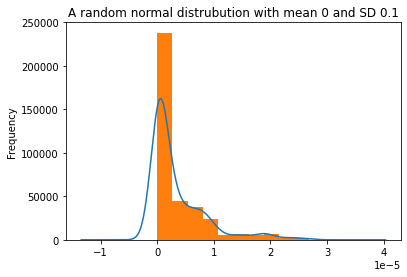

In [96]:
fig, ax = plt.subplots()
dataset_UK["Mortality_Rate"].plot.kde(ax=ax, legend=False, title='A random normal distrubution with mean 0 and SD 0.1')
dataset_UK["Mortality_Rate"].plot.hist(density=True, ax=ax)

In [97]:
dataset_UK.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [105]:
#importing Autoviz class
from autoviz.AutoViz_Class import AutoViz_Class       #Instantiate the AutoViz class
AV = AutoViz_Class()

Imported AutoViz_Class version: 0.0.84. Call using:
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 does not show plot but creates them and saves them in AutoViz_Plots directory in your local machine.


In [ ]:
df = AV.AutoViz("/content/gdrive/MyDrive/owid-covid-data.csv")

In [107]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [108]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [110]:
df["location"].nunique()

231

In [111]:
dataset = pd.read_csv("/content/dataset.csv")

In [ ]:
df = AV.AutoViz("/content/dataset.csv")

In [113]:
dataset.head()

,date,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
0,2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
1,2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2,2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
3,2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
4,2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [ ]:
df = AV.AutoViz("/content/dataset.csv", depVar = "Mortality_Rate")